# 1. Setup

In [29]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [30]:
language = 'Malayalam'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [31]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [32]:
cpu_count = os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

16
cuda


# 2. Define character class

In [33]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(668, 3)


,Character,Consonant,Glyph
0,അ,-,-
1,ആ,-,ാ
2,ഇ,-,ി
3,ഈ,-,ീ
4,ഉ,-,ു


In [34]:
#character_df[character_df['Consonant']=="-"]

In [35]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

74
['-', 'ഀ', 'ഁ', 'ഃ', 'അ', 'ആ', 'ഇ', 'ഈ', 'ഉ', 'ഊ', 'ഋ', 'ഌ', 'എ', 'ഏ', 'ഐ', 'ഒ', 'ഓ', 'ഔ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ', 'ാ', 'ി', 'ീ', 'ു', 'ൂ', 'ൃ', 'െ', 'േ', 'ൈ', 'ൊ', 'ോ', 'ൌ', '്', 'ൢ', 'ൺ', 'ൻ', 'ർ', 'ൽ', 'ൾ', 'ൿ']


In [36]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ഀ', 2: 'ഁ', 3: 'ഃ', 4: 'അ', 5: 'ആ', 6: 'ഇ', 7: 'ഈ', 8: 'ഉ', 9: 'ഊ', 10: 'ഋ', 11: 'ഌ', 12: 'എ', 13: 'ഏ', 14: 'ഐ', 15: 'ഒ', 16: 'ഓ', 17: 'ഔ', 18: 'ക', 19: 'ഖ', 20: 'ഗ', 21: 'ഘ', 22: 'ങ', 23: 'ച', 24: 'ഛ', 25: 'ജ', 26: 'ഝ', 27: 'ഞ', 28: 'ട', 29: 'ഠ', 30: 'ഡ', 31: 'ഢ', 32: 'ണ', 33: 'ത', 34: 'ഥ', 35: 'ദ', 36: 'ധ', 37: 'ന', 38: 'പ', 39: 'ഫ', 40: 'ബ', 41: 'ഭ', 42: 'മ', 43: 'യ', 44: 'ര', 45: 'റ', 46: 'ല', 47: 'ള', 48: 'ഴ', 49: 'വ', 50: 'ശ', 51: 'ഷ', 52: 'സ', 53: 'ഹ', 54: 'ാ', 55: 'ി', 56: 'ീ', 57: 'ു', 58: 'ൂ', 59: 'ൃ', 60: 'െ', 61: 'േ', 62: 'ൈ', 63: 'ൊ', 64: 'ോ', 65: 'ൌ', 66: '്', 67: 'ൢ', 68: 'ൺ', 69: 'ൻ', 70: 'ർ', 71: 'ൽ', 72: 'ൾ', 73: 'ൿ'}
{'-': 0, 'ഀ': 1, 'ഁ': 2, 'ഃ': 3, 'അ': 4, 'ആ': 5, 'ഇ': 6, 'ഈ': 7, 'ഉ': 8, 'ഊ': 9, 'ഋ': 10, 'ഌ': 11, 'എ': 12, 'ഏ': 13, 'ഐ': 14, 'ഒ': 15, 'ഓ': 16, 'ഔ': 17, 'ക': 18, 'ഖ': 19, 'ഗ': 20, 'ഘ': 21, 'ങ': 22, 'ച': 23, 'ഛ': 24, 'ജ': 25, 'ഝ': 26, 'ഞ': 27, 'ട': 28, 'ഠ': 29, 'ഡ': 30, 'ഢ': 31, 'ണ': 32, 'ത': 33, 'ഥ': 34, 'ദ': 35, 'ധ': 36, 'ന': 37, 'പ': 38, '

# 3. Define data loader

In [37]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [38]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 
testset = IndianSceneTextDataset(test_dir) 
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=1, shuffle=False)
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

400000 5000 5000
25000 313 313


In [39]:
image_batch, text_batch, image_fn_batch = iter(train_loader).next()
print(image_batch.size())
print(text_batch)

torch.Size([16, 3, 50, 200])
('ജഗതി', 'ഷഹബാസ്', 'ജീൻ', 'അമതേരസു', 'മലൈക', 'ഓലി', 'കായൽ', 'ഓവർ', 'നഗർ', 'ചീനവല', 'സഖി', 'ഉടമ്പടി', 'അനുഷ്ക', 'പല', 'ഓലി', 'പാൽ')


In [40]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

In [41]:
for text in text_batch:
    print(text, tokenize(text))

ജഗതി ['ജ', 'ഗ', 'ത', 'ി']
ഷഹബാസ് ['ഷ', 'ഹ', 'ബ', 'ാ', 'സ', '്']
ജീൻ ['ജ', 'ീ', 'ൻ']
അമതേരസു ['അ', 'മ', 'ത', 'േ', 'ര', 'സ', 'ു']
മലൈക ['മ', 'ല', 'ൈ', 'ക']
ഓലി ['ഓ', 'ല', 'ി']
കായൽ ['ക', 'ാ', 'യ', 'ൽ']
ഓവർ ['ഓ', 'വ', 'ർ']
നഗർ ['ന', 'ഗ', 'ർ']
ചീനവല ['ച', 'ീ', 'ന', 'വ', 'ല']
സഖി ['സ', 'ഖ', 'ി']
ഉടമ്പടി ['ഉ', 'ട', 'മ', '്', 'പ', 'ട', 'ി']
അനുഷ്ക ['അ', 'ന', 'ു', 'ഷ', '്', 'ക']
പല ['പ', 'ല']
ഓലി ['ഓ', 'ല', 'ി']
പാൽ ['പ', 'ാ', 'ൽ']


# 4. Define model

In [42]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [43]:
for p in resnet.parameters():
    pass#p.requires_grad = False

In [44]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

In [45]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [46]:
crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=256)
#crnn.apply(weights_init)
crnn = crnn.to(device)

In [47]:
#crnn

In [48]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('ജഗതി', 'ഷഹബാസ്', 'ജീൻ', 'അമതേരസു', 'മലൈക', 'ഓലി', 'കായൽ', 'ഓവർ', 'നഗർ', 'ചീനവല', 'സഖി', 'ഉടമ്പടി', 'അനുഷ്ക', 'പല', 'ഓലി', 'പാൽ')
torch.Size([13, 16, 74])


In [49]:
#text_batch_logits.log_softmax(2)

# 5. Define loss

In [50]:
criterion = nn.CTCLoss(blank=0)

In [51]:
def encode_text_batch(text_batch):
    
    text_batch = [tokenize(text) for text in text_batch]
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = []
    for text in text_batch:
        for token in text:
            text_batch_concat.append(token)
 
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [52]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [53]:
compute_loss(text_batch, text_batch_logits)

tensor(12.8232, device='cuda:0', grad_fn=<MeanBackward0>)

# 6. Train model

In [54]:
# Hyperparameters: Data Loading
batch_size = 64

# Hyperparameters: Model Architecture
rnn_hidden_size = 256

# Hyperparameters: Training
num_epochs = 40
lr = 0.001
weight_decay = 1e-5
clip_norm = 5
step_size = 5
gamma = 0.90

In [55]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=rnn_hidden_size)
#crnn.apply(weights_init)
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [56]:
epoch_losses = []
epoch_losses_val = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    epoch_loss_list_val = []
    num_updates_epoch = 0

    crnn.train()
    for image_batch, text_batch, image_fn_batch in tqdm(train_loader, leave=False, desc="Train"):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    crnn.eval()
    for image_batch, text_batch, image_fn_batch in tqdm(val_loader, leave=False, desc="Val"):
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
        epoch_loss_list_val.append(iteration_loss)


    epoch_loss = np.mean(epoch_loss_list)
    epoch_loss_val = np.mean(epoch_loss_list_val)
    print("Epoch:{}    TrainLoss:{}    ValLoss:{}    NumUpdates:{}    LR:{}".\
          format(epoch, epoch_loss, epoch_loss_val, num_updates_epoch, optimizer.param_groups[0]['lr']))
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step()
    
    if epoch % 10 == 0:
        model_path = f'Models/{language}-Unicode-e{epoch}.pth'
        torch.save(crnn.state_dict(), model_path)

Epoch:1    TrainLoss:2.031014564638138    ValLoss:1.2202973803387414    NumUpdates:6250    LR:0.001


Epoch:2    TrainLoss:1.1654155935096742    ValLoss:1.048411509658717    NumUpdates:6250    LR:0.001


Epoch:3    TrainLoss:1.022993144774437    ValLoss:0.9405682630176786    NumUpdates:6250    LR:0.001


Epoch:4    TrainLoss:0.9502323412799836    ValLoss:0.8845466722415972    NumUpdates:6250    LR:0.001


Epoch:5    TrainLoss:0.8982050639796257    ValLoss:0.8518984363048892    NumUpdates:6250    LR:0.001


Epoch:6    TrainLoss:0.8367347460794449    ValLoss:0.7954640769505803    NumUpdates:6250    LR:0.0009000000000000001


Epoch:7    TrainLoss:0.8032081012916565    ValLoss:0.7619964118245282    NumUpdates:6250    LR:0.0009000000000000001


Epoch:8    TrainLoss:0.7780269188094139    ValLoss:0.755320715753338    NumUpdates:6250    LR:0.0009000000000000001


Epoch:9    TrainLoss:0.7590575615668297    ValLoss:0.7544728136515315    NumUpdates:6250    LR:0.0009000000000000001


Epoch:10    TrainLoss:0.7404748695373535    ValLoss:0.7350879005993469    NumUpdates:6250    LR:0.0009000000000000001


Epoch:11    TrainLoss:0.7035916748332978    ValLoss:0.7345456330082084    NumUpdates:6250    LR:0.0008100000000000001


Epoch:12    TrainLoss:0.686199100613594    ValLoss:0.7301419607446163    NumUpdates:6250    LR:0.0008100000000000001


Epoch:13    TrainLoss:0.6731089505076409    ValLoss:0.7102304527276679    NumUpdates:6250    LR:0.0008100000000000001


Epoch:14    TrainLoss:0.659545272910595    ValLoss:0.7142821991745429    NumUpdates:6250    LR:0.0008100000000000001


Epoch:15    TrainLoss:0.6511063516950607    ValLoss:0.6778881515883193    NumUpdates:6250    LR:0.0008100000000000001


Epoch:16    TrainLoss:0.6220321176576614    ValLoss:0.6782844292966625    NumUpdates:6250    LR:0.000729


Epoch:17    TrainLoss:0.6085278089594841    ValLoss:0.6704895998103709    NumUpdates:6250    LR:0.000729


Epoch:18    TrainLoss:0.6008729908597469    ValLoss:0.6632288407675827    NumUpdates:6250    LR:0.000729


Epoch:19    TrainLoss:0.5929586383271217    ValLoss:0.6667174082013625    NumUpdates:6250    LR:0.000729


Epoch:20    TrainLoss:0.585389392747879    ValLoss:0.6700011755846724    NumUpdates:6250    LR:0.000729


Epoch:21    TrainLoss:0.5604283002614975    ValLoss:0.6474174698696861    NumUpdates:6250    LR:0.0006561000000000001


Epoch:22    TrainLoss:0.5508631205749511    ValLoss:0.6656631506696532    NumUpdates:6250    LR:0.0006561000000000001


Epoch:23    TrainLoss:0.543604355186224    ValLoss:0.6619675936578195    NumUpdates:6250    LR:0.0006561000000000001


Epoch:24    TrainLoss:0.5381323683583736    ValLoss:0.6542726392987408    NumUpdates:6250    LR:0.0006561000000000001


Epoch:25    TrainLoss:0.5330056438922882    ValLoss:0.6364352638962902    NumUpdates:6250    LR:0.0006561000000000001


Epoch:26    TrainLoss:0.5103064828431606    ValLoss:0.6318334869191616    NumUpdates:6250    LR:0.00059049


Epoch:27    TrainLoss:0.5003157955360412    ValLoss:0.6505254375029214    NumUpdates:6250    LR:0.00059049


Epoch:28    TrainLoss:0.49429732460021975    ValLoss:0.6644467153126681    NumUpdates:6250    LR:0.00059049


Epoch:29    TrainLoss:0.4900760647428036    ValLoss:0.6564411800118941    NumUpdates:6250    LR:0.00059049


Epoch:30    TrainLoss:0.48706852606415746    ValLoss:0.6444621274742899    NumUpdates:6250    LR:0.00059049


Epoch:31    TrainLoss:0.4646773544073105    ValLoss:0.6488639817962164    NumUpdates:6250    LR:0.000531441


Epoch:32    TrainLoss:0.4573355705034733    ValLoss:0.6282587666300279    NumUpdates:6250    LR:0.000531441


Epoch:33    TrainLoss:0.4507824211215973    ValLoss:0.6253248592720756    NumUpdates:6250    LR:0.000531441


Epoch:34    TrainLoss:0.4476937148118019    ValLoss:0.6510138824770723    NumUpdates:6250    LR:0.000531441


Epoch:35    TrainLoss:0.44446451549887656    ValLoss:0.6390564958505993    NumUpdates:6250    LR:0.000531441


Epoch:36    TrainLoss:0.4248572656196356    ValLoss:0.6456907206698309    NumUpdates:6250    LR:0.0004782969


Epoch:37    TrainLoss:0.41772087443053724    ValLoss:0.6538436871163452    NumUpdates:6250    LR:0.0004782969


Epoch:38    TrainLoss:0.413164926123023    ValLoss:0.6303898835483985    NumUpdates:6250    LR:0.0004782969


Epoch:39    TrainLoss:0.4094137739098072    ValLoss:0.6369504960654657    NumUpdates:6250    LR:0.0004782969


Epoch:40    TrainLoss:0.40576508468925954    ValLoss:0.6573166160643855    NumUpdates:6250    LR:0.0004782969



In [57]:
model_path = f'Models/{language}-Unicode.pth'
torch.save(crnn.state_dict(), model_path)

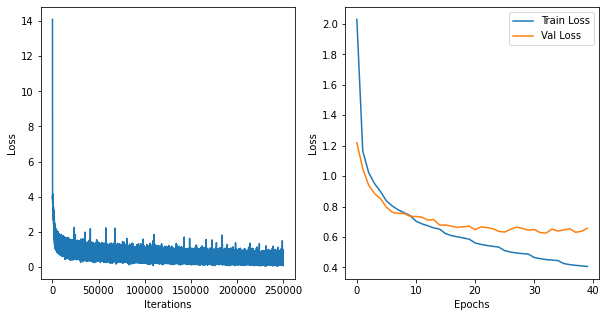

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(iteration_losses)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(epoch_losses, label="Train Loss")
ax2.plot(epoch_losses_val, label="Val Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()

# 7. Make predictions

In [59]:
#trainset = IndianSceneTextDataset(train_dir) 
#valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir) 

#train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
#val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [60]:
model_path = f'Models/{language}-Unicode.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

In [61]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [62]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [63]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [64]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(400000, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,മിശ്രസഹോദരന്മാർ_3_547_2.jpg,മിശ്രസഹോദരന്മ,ചാച്കതരരരങങങൾ
1,കഥ_15_4507_1.jpg,കഥ,ക-----------ഥ
2,ആർ_5_391_2.jpg,ആർ,ആ-----------ർ
3,വഡോമ_11_711_2.jpg,വഡോമ,വ---ഡ----ോ--മ
4,തായമ്പക_8_1069_0.jpg,തായമ്പക,ത--ായയ-മ്പ-കക


In [65]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [66]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [67]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [68]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [69]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 8. Evaluate the model

In [70]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.752275 0.6734 0.7074


In [71]:
for max_edit_distance in range(3+1):
    print("Max Edit Distance", max_edit_distance)
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    print(train_accuracy, val_accuracy, test_accuracy)
    print("*"*50)

Max Edit Distance 0
0.752275 0.6734 0.7074
**************************************************
Max Edit Distance 1
0.8431975 0.768 0.8068
**************************************************
Max Edit Distance 2
0.898015 0.8414 0.8736
**************************************************
Max Edit Distance 3
0.9392275 0.904 0.9312
**************************************************


In [72]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=2):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

('Actual:', 'ബാലരാമവർമ്മ', 'Prediction:', 'ഓ--ല-വ-ഘർബർ-ജ', 'Prediction Corrected:', 'ഓലവഘർബർജ')


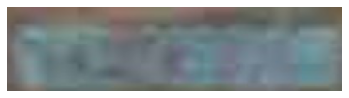

('Actual:', 'ശിഖ', 'Prediction:', 'അ------------', 'Prediction Corrected:', 'അ')


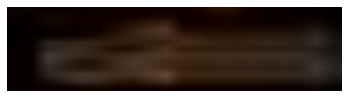

('Actual:', 'ജൂൺ', 'Prediction:', 'ക-----------ൻ', 'Prediction Corrected:', 'കൻ')


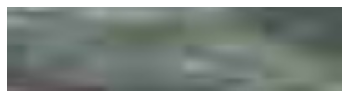

('Actual:', 'നവരോജ്', 'Prediction:', 'ന----ന------്', 'Prediction Corrected:', 'നന്')


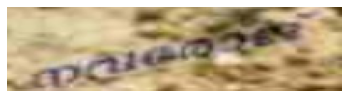

('Actual:', 'ഇത്', 'Prediction:', 'ഇ-----------ൻ', 'Prediction Corrected:', 'ഇൻ')


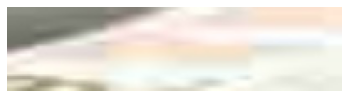

('Actual:', 'അതേ', 'Prediction:', 'അ-----------ർ', 'Prediction Corrected:', 'അർ')


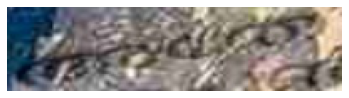

('Actual:', 'എന്ന', 'Prediction:', 'എ-----------ന', 'Prediction Corrected:', 'എന')


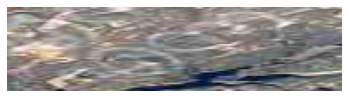

('Actual:', 'എരുമകളെ', 'Prediction:', 'ഏ---രുമക്കള-െ', 'Prediction Corrected:', 'ഏരുമക്കളെ')


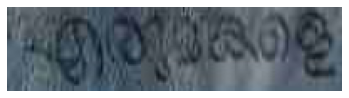

('Actual:', 'ചുരുട്ട', 'Prediction:', 'ച---ിര------ർ', 'Prediction Corrected:', 'ചിരർ')


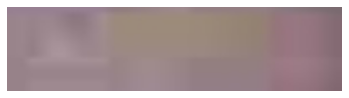

('Actual:', 'ഡ്രബ', 'Prediction:', 'അ-----------ൻ', 'Prediction Corrected:', 'അൻ')


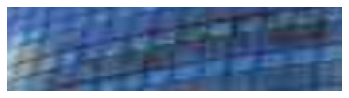

('Actual:', 'മേജർ', 'Prediction:', 'ന--േ---ഹ----റ', 'Prediction Corrected:', 'നേഹറ')


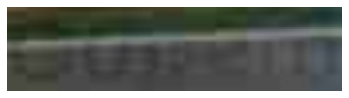

('Actual:', 'ഡെൻവർഒരു', 'Prediction:', 'ഡ-െെ-ൻവവർഒ-തെ', 'Prediction Corrected:', 'ഡെൻവർഒതെ')


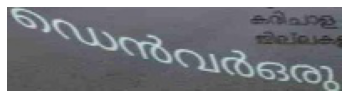

('Actual:', 'കനവാളന്', 'Prediction:', 'ക----വ-----ണ്', 'Prediction Corrected:', 'കവണ്')


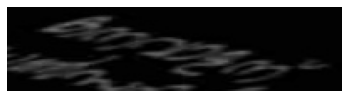

('Actual:', 'മക്കാബിയൻ', 'Prediction:', 'അ-----------ൻ', 'Prediction Corrected:', 'അൻ')


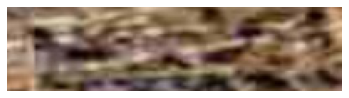

('Actual:', 'ഇൻഗെർ', 'Prediction:', 'ഇ----ൻ------ർ', 'Prediction Corrected:', 'ഇൻർ')


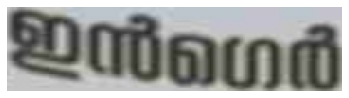

('Actual:', 'നന്ദന', 'Prediction:', 'ന-----------ൻ', 'Prediction Corrected:', 'നൻ')


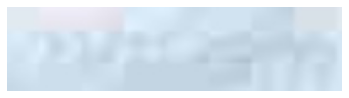

('Actual:', 'സവൂൻഗ', 'Prediction:', 'സ---വ്വ-ൻൻ-ഗഗ', 'Prediction Corrected:', 'സവ്വൻഗ')


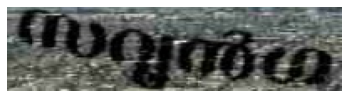

('Actual:', 'സോഫല', 'Prediction:', 'ക---ോോ-ഹ----ല', 'Prediction Corrected:', 'കോഹല')


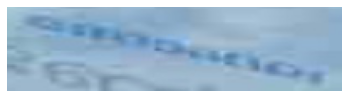

('Actual:', 'പ്ലസൻഷ്യ', 'Prediction:', 'പ്ര-സ---ൻപ-്യ', 'Prediction Corrected:', 'പ്രസൻപ്യ')


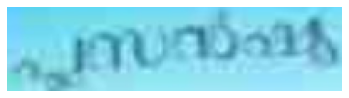

('Actual:', 'രഹസ്യ', 'Prediction:', 'അ-----------ൻ', 'Prediction Corrected:', 'അൻ')


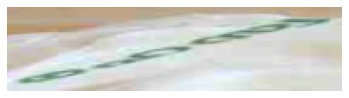

In [73]:
visualize_misclassifications('Train')

('Actual:', 'തഗാബൂൻ', 'Prediction:', 'ത--ത-ര-ബ-ൂ--ൻ', 'Prediction Corrected:', 'തതരബൂൻ')


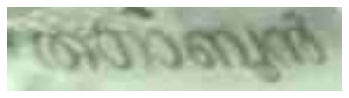

('Actual:', 'ഇരട്ടത്തലയൻ', 'Prediction:', 'ഇരട്ടട്്ലയയയൻ', 'Prediction Corrected:', 'ഇരട്ട്ലയൻ')


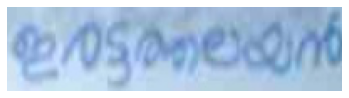

('Actual:', 'ഹീര', 'Prediction:', 'ഉ-----------ള', 'Prediction Corrected:', 'ഉള')


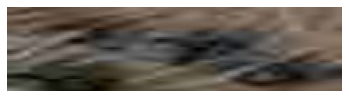

('Actual:', 'ബലേഹർ', 'Prediction:', 'അ----യ-ഹ----ർ', 'Prediction Corrected:', 'അയഹർ')


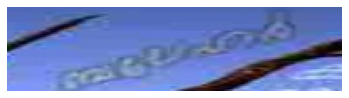

('Actual:', 'ഒല്ലൂർ', 'Prediction:', 'ഒ---ല---ൂൂൂ-ർ', 'Prediction Corrected:', 'ഒലൂർ')


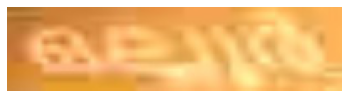

('Actual:', 'തമ്മിൽ', 'Prediction:', 'ക-----പ-----ൻ', 'Prediction Corrected:', 'കപൻ')


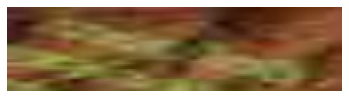

('Actual:', 'ഇറ്റലി', 'Prediction:', 'ഈ-----------ട', 'Prediction Corrected:', 'ഈട')


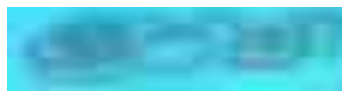

('Actual:', 'ടെൻ', 'Prediction:', 'അ-----------ൻ', 'Prediction Corrected:', 'അൻ')


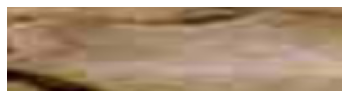

('Actual:', 'ഒരു', 'Prediction:', 'സ-----------മ', 'Prediction Corrected:', 'സമ')


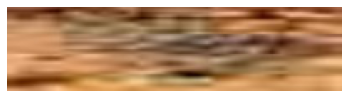

('Actual:', 'അഥവാ', 'Prediction:', 'ജ-----ഥ-----ാ', 'Prediction Corrected:', 'ജഥാ')


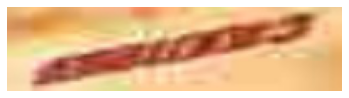

('Actual:', 'റഅദ്', 'Prediction:', 'ദ---ങ-------ൺ', 'Prediction Corrected:', 'ദങൺ')


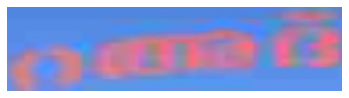

('Actual:', 'നമ്പീശൻ', 'Prediction:', 'ന--സ്മീീ----ൺ', 'Prediction Corrected:', 'നസ്മീൺ')


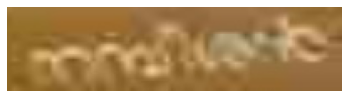

('Actual:', 'മുത്തപ്പൻപുഴ', 'Prediction:', 'മുത്തപപപൻപ-ൂഴ', 'Prediction Corrected:', 'മുത്തപൻപൂഴ')


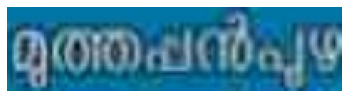

('Actual:', 'ജഗപൊഗ', 'Prediction:', 'ക------------', 'Prediction Corrected:', 'ക')


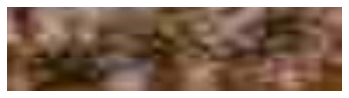

('Actual:', 'കമ', 'Prediction:', 'ഗ-----------ർ', 'Prediction Corrected:', 'ഗർ')


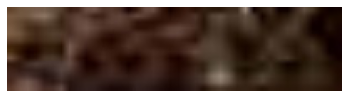

('Actual:', 'ഇമെയിൽ', 'Prediction:', 'ഇ-----------ൽ', 'Prediction Corrected:', 'ഇൽ')


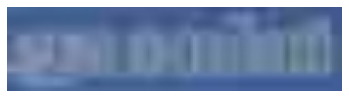

('Actual:', 'ഗർഹി', 'Prediction:', 'ഹ-----ര-----ൻ', 'Prediction Corrected:', 'ഹരൻ')


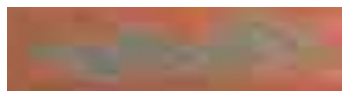

('Actual:', 'സഹൽ', 'Prediction:', 'ഇ----ഹ-വവ---ൽ', 'Prediction Corrected:', 'ഇഹവൽ')


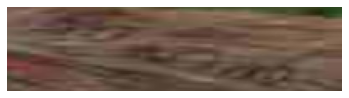

('Actual:', 'ചക്മ', 'Prediction:', 'ആ-----ക---്-യ', 'Prediction Corrected:', 'ആക്യ')


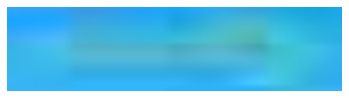

('Actual:', 'ഗലേൻ', 'Prediction:', 'ക-----ക-----ന', 'Prediction Corrected:', 'കകന')


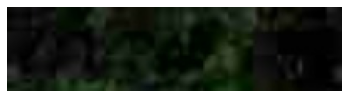

In [74]:
visualize_misclassifications('Val')

('Actual:', 'ഏല', 'Prediction:', 'പ-----ുഴ----ല', 'Prediction Corrected:', 'പുഴല')


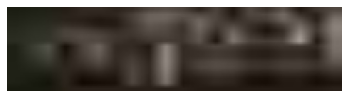

('Actual:', 'കോൾമ', 'Prediction:', 'ക----------കർ', 'Prediction Corrected:', 'കകർ')


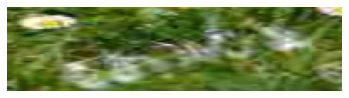

('Actual:', 'ഐസോബാറുകൾ', 'Prediction:', 'കര്സസറബസ്സ്കൾ', 'Prediction Corrected:', 'കര്സറബസ്സ്കൾ')


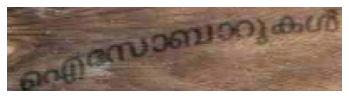

('Actual:', 'ഗദ', 'Prediction:', 'ഓ------ങ--്്ക', 'Prediction Corrected:', 'ഓങ്ക')


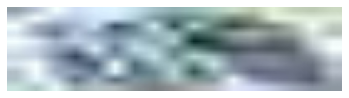

('Actual:', 'തോട', 'Prediction:', 'ബ------ര----ട', 'Prediction Corrected:', 'ബരട')


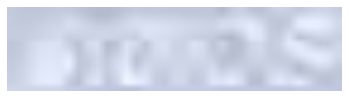

('Actual:', 'ങ്ങളിൽ', 'Prediction:', 'ങങങങ--ള-ി---ൽ', 'Prediction Corrected:', 'ങളിൽ')


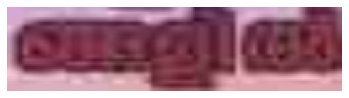

('Actual:', 'റോസ', 'Prediction:', 'ജ-----ാ-----സ', 'Prediction Corrected:', 'ജാസ')


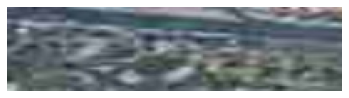

('Actual:', 'നാഭ', 'Prediction:', 'പ-----------ി', 'Prediction Corrected:', 'പി')


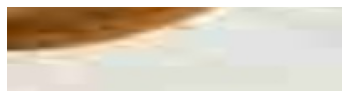

('Actual:', 'മഴവാക', 'Prediction:', 'ഇ-----------ൽ', 'Prediction Corrected:', 'ഇൽ')


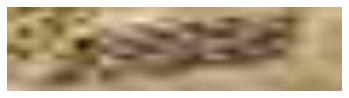

('Actual:', 'മജ്മ', 'Prediction:', 'ഉ-----------ാ', 'Prediction Corrected:', 'ഉാ')


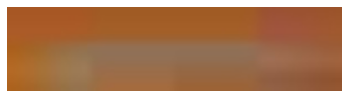

('Actual:', 'ഉദാ', 'Prediction:', 'ക-----------ൻ', 'Prediction Corrected:', 'കൻ')


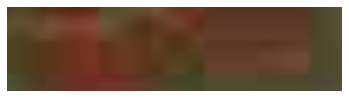

('Actual:', 'ടഫ്', 'Prediction:', 'ക------------', 'Prediction Corrected:', 'ക')


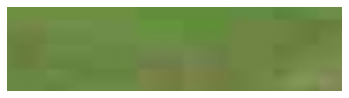

('Actual:', 'മന', 'Prediction:', 'ഉ-----ദ-----ു', 'Prediction Corrected:', 'ഉദു')


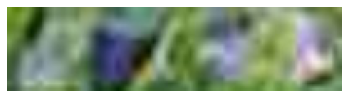

('Actual:', 'ഉമ്മ', 'Prediction:', 'ഉ-----------ന', 'Prediction Corrected:', 'ഉന')


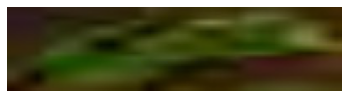

('Actual:', 'കളിൽ', 'Prediction:', 'ക----മ--ീ---ർ', 'Prediction Corrected:', 'കമീർ')


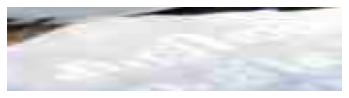

('Actual:', 'ഇന്റർഫേസ്', 'Prediction:', 'ഇ-ന്റർഹേേറ-സ്', 'Prediction Corrected:', 'ഇന്റർഹേറസ്')


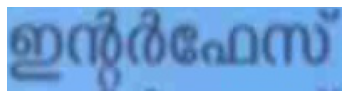

('Actual:', 'കഴുവേറ്റൽ', 'Prediction:', 'ക-ുഴുവേേറററ-ൽ', 'Prediction Corrected:', 'കുഴുവേറൽ')


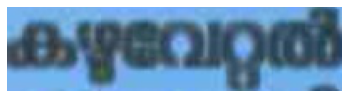

('Actual:', 'ആർഎൽ', 'Prediction:', 'അ----ൻഎ-----ൽ', 'Prediction Corrected:', 'അൻഎൽ')


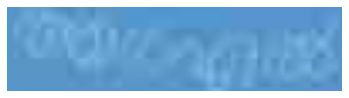

('Actual:', 'അൽ', 'Prediction:', 'സ----------ടി', 'Prediction Corrected:', 'സടി')


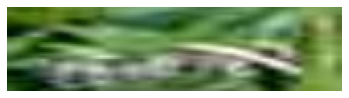

('Actual:', 'കൂടുതൽ', 'Prediction:', 'ക-----------ൽ', 'Prediction Corrected:', 'കൽ')


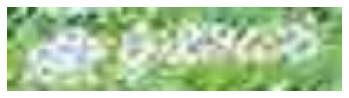

In [75]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Loss cannot be reduced beyond 0.54 in val set (after 20 epochs)